In [3]:
import sys

import numpy as np
import pandas as pd
import datetime
import time

# music api imports
import spotipy
import spotipy.util as util
import billboard
import pygn
import pylast

import requests
import re
from bs4 import BeautifulSoup
from time import sleep
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid", {'axes.grid' : False})

In [4]:
from sklearn import cross_validation, datasets, linear_model, grid_search, metrics, ensemble, tree
from sklearn import pipeline, manifold, preprocessing, feature_selection, decomposition
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [6]:
master_songs = pd.read_pickle('data/master_songs.pkl')

## Visualizing missing data

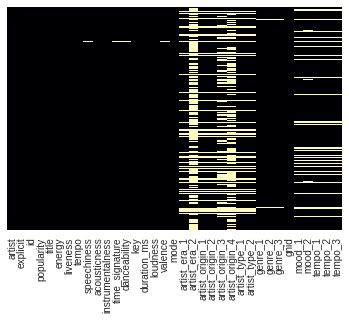

In [7]:
sns.heatmap(master_songs.isnull(),yticklabels=False,cbar=False, cmap='magma');

In [8]:
# Dropping all values with Null Moods (since this is to be the target)
master_songs_1 = master_songs[master_songs['mood_1'].notnull()].copy()

In [9]:
master_songs_1.count(axis=0)

artist              21500
explicit            21500
id                  21500
popularity          21500
title               21500
energy              21500
liveness            21494
tempo               21500
speechiness         21468
acousticness        21500
instrumentalness    21499
time_signature      21468
danceability        21468
key                 21500
duration_ms         21500
loudness            21500
valence             21466
mode                21500
artist_era_1        18563
artist_era_2         7156
artist_origin_1     18569
artist_origin_2     18549
artist_origin_3     13773
artist_origin_4      9817
artist_type_1       18563
artist_type_2       18527
genre_1             21368
genre_2             21368
genre_3             21368
gnid                21500
mood_1              21500
mood_2              21059
tempo_1             21499
tempo_2             21499
tempo_3             21499
dtype: int64

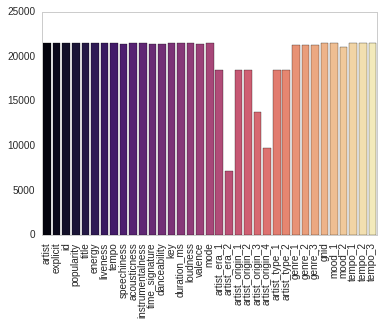

In [10]:
sns.barplot(master_songs_1.count(axis=0).index, master_songs_1.count(axis=0).values, palette='magma')
plt.xticks(rotation=90);

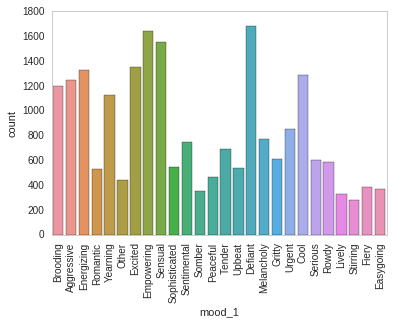

In [11]:
# Some moods are under-represented in the data compared to others
sns.countplot(master_songs_1.mood_1)
plt.xticks(rotation=90);

## Handling missing data

In [1]:
numerical = ['popularity', 'energy', 'liveness',  'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'danceability', 'duration_ms', 'loudness', 'valence', 'mode']
categorical = ['artist_era_1', 'artist_origin_1', 'artist_origin_2', 'artist_type_1', 'artist_type_2', 'genre_1', 'genre_2', 'genre_3']

In [13]:
# Reinitializing master_songs_1
master_songs_1 = master_songs[master_songs['mood_1'].notnull()].copy()

In [14]:
def clean_data(df):
    # 1. Drop non-important/duplicate columns (e.g., artist_era_2, artist_origin_3, artist_origin_4, tempo_1, tempo_2, tempo_3)
    df = df.drop(['artist_era_2', 'artist_origin_3', 'artist_origin_4', 'tempo_1', 'tempo_2', 'tempo_2', 'tempo_3'], axis=1)

    
    # 2. Impute values for missing numerical song attributes (based on average)
    for i in numerical:
        df[i].fillna(value=df[i].mean(), inplace=True)
    
    # 3. Impute values for missing categorical attributes (based on mode)
    for i in categorical:
        df[i].fillna(value=df[i].mode()[0], inplace=True)
    
    return df

In [15]:
master_songs_2 = clean_data(master_songs_1)
# Ignoring mood_2 for now
# master_songs_2['mood_2'] = master_songs_2.groupby('mood_1', axis=1)['mood_2'].transform(lambda x: x.fillna(value = x.mode()[0]))

In [16]:
master_songs_2.tail()

,artist,explicit,id,popularity,title,energy,liveness,tempo,speechiness,acousticness,...,artist_origin_1,artist_origin_2,artist_type_1,artist_type_2,genre_1,genre_2,genre_3,gnid,mood_1,mood_2
24562,Blake Shelton,False,1HwAeValR9dJzAf8Erlv3s,26,Came Here to Forget,0.6640,0.110,130.034,0.0283,0.334000,...,North America,United States,Male,Male,Traditional,Country,Contemporary Country,630820771-FD595ACE0CFA6FF1877B9A89ED646167,Brooding,Dreamy Brooding
24563,Bent,False,4VIIlPZ9yIYiMjwsTywgRd,24,As You Fall - Kyau & Albert Remix,0.7120,0.319,132.768,0.0428,0.000761,...,Western Europe,United Kingdom,Male,Male Duo,Electronica,"Downtempo, Lounge & Ambient",General Downtempo,265811879-E2C518606C4D4167A6DE06A1640F39EA,Excited,Euphoric Energy
24564,Danny Elfman,False,1eZmTjKm5UHf7tcfjbnMOI,39,Finale,0.0877,0.111,120.930,0.0398,0.979000,...,North America,United States,Male,Male,Soundtrack,Original Film/TV Music,General Film Music,12742567-E90494E46779AA2A8A2DC933328FF263,Serious,Thrilling
24565,Trey Gunn,False,6B9FlPonSCAQBLqGVCnhoR,14,The Joy of Molybdenum (feat. The Trey Gunn Band),0.9170,0.103,122.751,0.0584,0.041500,...,North America,United States,Male,Male,Rock,70's Rock,Classic Prog,9994566-653EBF54BF69F2C8CC0A3434E16BA0E5,Energizing,Abstract Beat
24566,Culture Club,False,3XDeeP9wBZzGhIPZmLfEEx,54,Karma Chameleon,0.5520,0.206,92.056,0.0337,0.214000,...,Western Europe,United Kingdom,Male,Male Group,Alternative & Punk,New Wave Pop,New Wave Pop,7456142-E2B684AF38579A7DCE07F9ABF205E871,Upbeat,Soulful / Easygoing


### Load Pickle Point

In [156]:
master_songs_2.to_pickle('data/master_songs_2.pkl')

In [5]:
master_songs_2 = pd.read_pickle('data/master_songs_2.pkl')

In [6]:
master_songs_2.iloc[:,:20]

,artist,explicit,id,popularity,title,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,artist_era_1,artist_origin_1
0,Nirvana,False,3FUsMXBxA4V7eUwQ7B0HQO,48,Love Buzz,0.885000,0.1690,138.153,0.035400,0.000032,0.196000,4,0.470000,3.0,215120.0,-7.224,0.780000,1.0,1990s,North America
1,The Presidents Of The United States Of America,False,2JdzB67NvIa90K4gEZPLeX,58,Lump,0.873000,0.1650,142.726,0.038600,0.004680,0.000000,4,0.499000,6.0,134200.0,-3.902,0.869000,1.0,1990s,North America
2,Stanton Warriors,False,0zXLMZUCYZCx8Bq4jCr174,30,So Sweet,0.936000,0.1180,127.997,0.042500,0.000531,0.594000,4,0.715000,4.0,201337.0,-6.127,0.106000,0.0,2000s,Western Europe
4,Robyn,False,01NJd6s7Kyn6NSsPp503sh,28,Be Mine! - Live At The Cherrytree House,0.249000,0.1140,116.599,0.045100,0.955000,0.000000,4,0.533000,0.0,272053.0,-8.532,0.513000,0.0,2000s,Scandinavia
5,Pearl Jam,False,6qgpO647NPBUvBkm56vV7d,5,Black,0.548000,0.1790,76.020,0.028700,0.294000,0.000000,4,0.376000,4.0,343667.0,-10.580,0.233000,0.0,1990s,North America
6,Sam Hunt,False,3wx2kQWPn9p5UppQbNhPAk,67,Leave The Night On,0.953000,0.3490,171.971,0.062400,0.099600,0.000000,4,0.516000,9.0,192160.0,-3.828,0.849000,1.0,2010s,North America
7,George Carlin,False,5DuxYjcuebFPontojL1NEE,0,War Pictures,0.546000,0.1470,72.940,0.961000,0.921000,0.000000,3,0.611000,7.0,222200.0,-10.444,0.491000,1.0,1970s,North America
8,Kaya May,False,4eg3wsiTrPa7KpwVai2VY7,56,"Hands to Myself, Love Yourself, Perfect (Acous...",0.445000,0.1130,110.056,0.050000,0.057500,0.000000,4,0.702000,9.0,226893.0,-9.693,0.326000,0.0,2010s,North America
9,Notaker,False,341ShRaeysVdxLetlI391K,56,Infinite,0.669000,0.1080,99.987,0.048300,0.093700,0.820000,4,0.633000,1.0,355200.0,-8.124,0.038400,0.0,2010s,North America
10,Thomas Rhett,False,4vLRCGOBz4zIS8nEHk5v9j,54,I Feel Good,0.584000,0.0677,106.967,0.036600,0.006580,0.000000,4,0.834000,3.0,195427.0,-7.238,0.964000,0.0,2010s,North America


## Exploring the Data

In [17]:
master_songs_2.count(axis=0)

artist              21500
explicit            21500
id                  21500
popularity          21500
title               21500
energy              21500
liveness            21500
tempo               21500
speechiness         21500
acousticness        21500
instrumentalness    21500
time_signature      21468
danceability        21500
key                 21500
duration_ms         21500
loudness            21500
valence             21500
mode                21500
artist_era_1        21500
artist_origin_1     21500
artist_origin_2     21500
artist_type_1       21500
artist_type_2       21500
genre_1             21500
genre_2             21500
genre_3             21500
gnid                21500
mood_1              21500
mood_2              21059
dtype: int64

In [18]:
moods = list(master_songs_2.mood_1.unique())

In [ ]:
# Make this work later
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,10));

axes = axes.flatten()

for i, j in enumerate(moods):
    sns.barplot(x = numerical, data = master_songs_2[j], ax=axes[i])
    axes[i].set_title(j)
    axes[i].set_xticklabels(numerical, rotation=90);

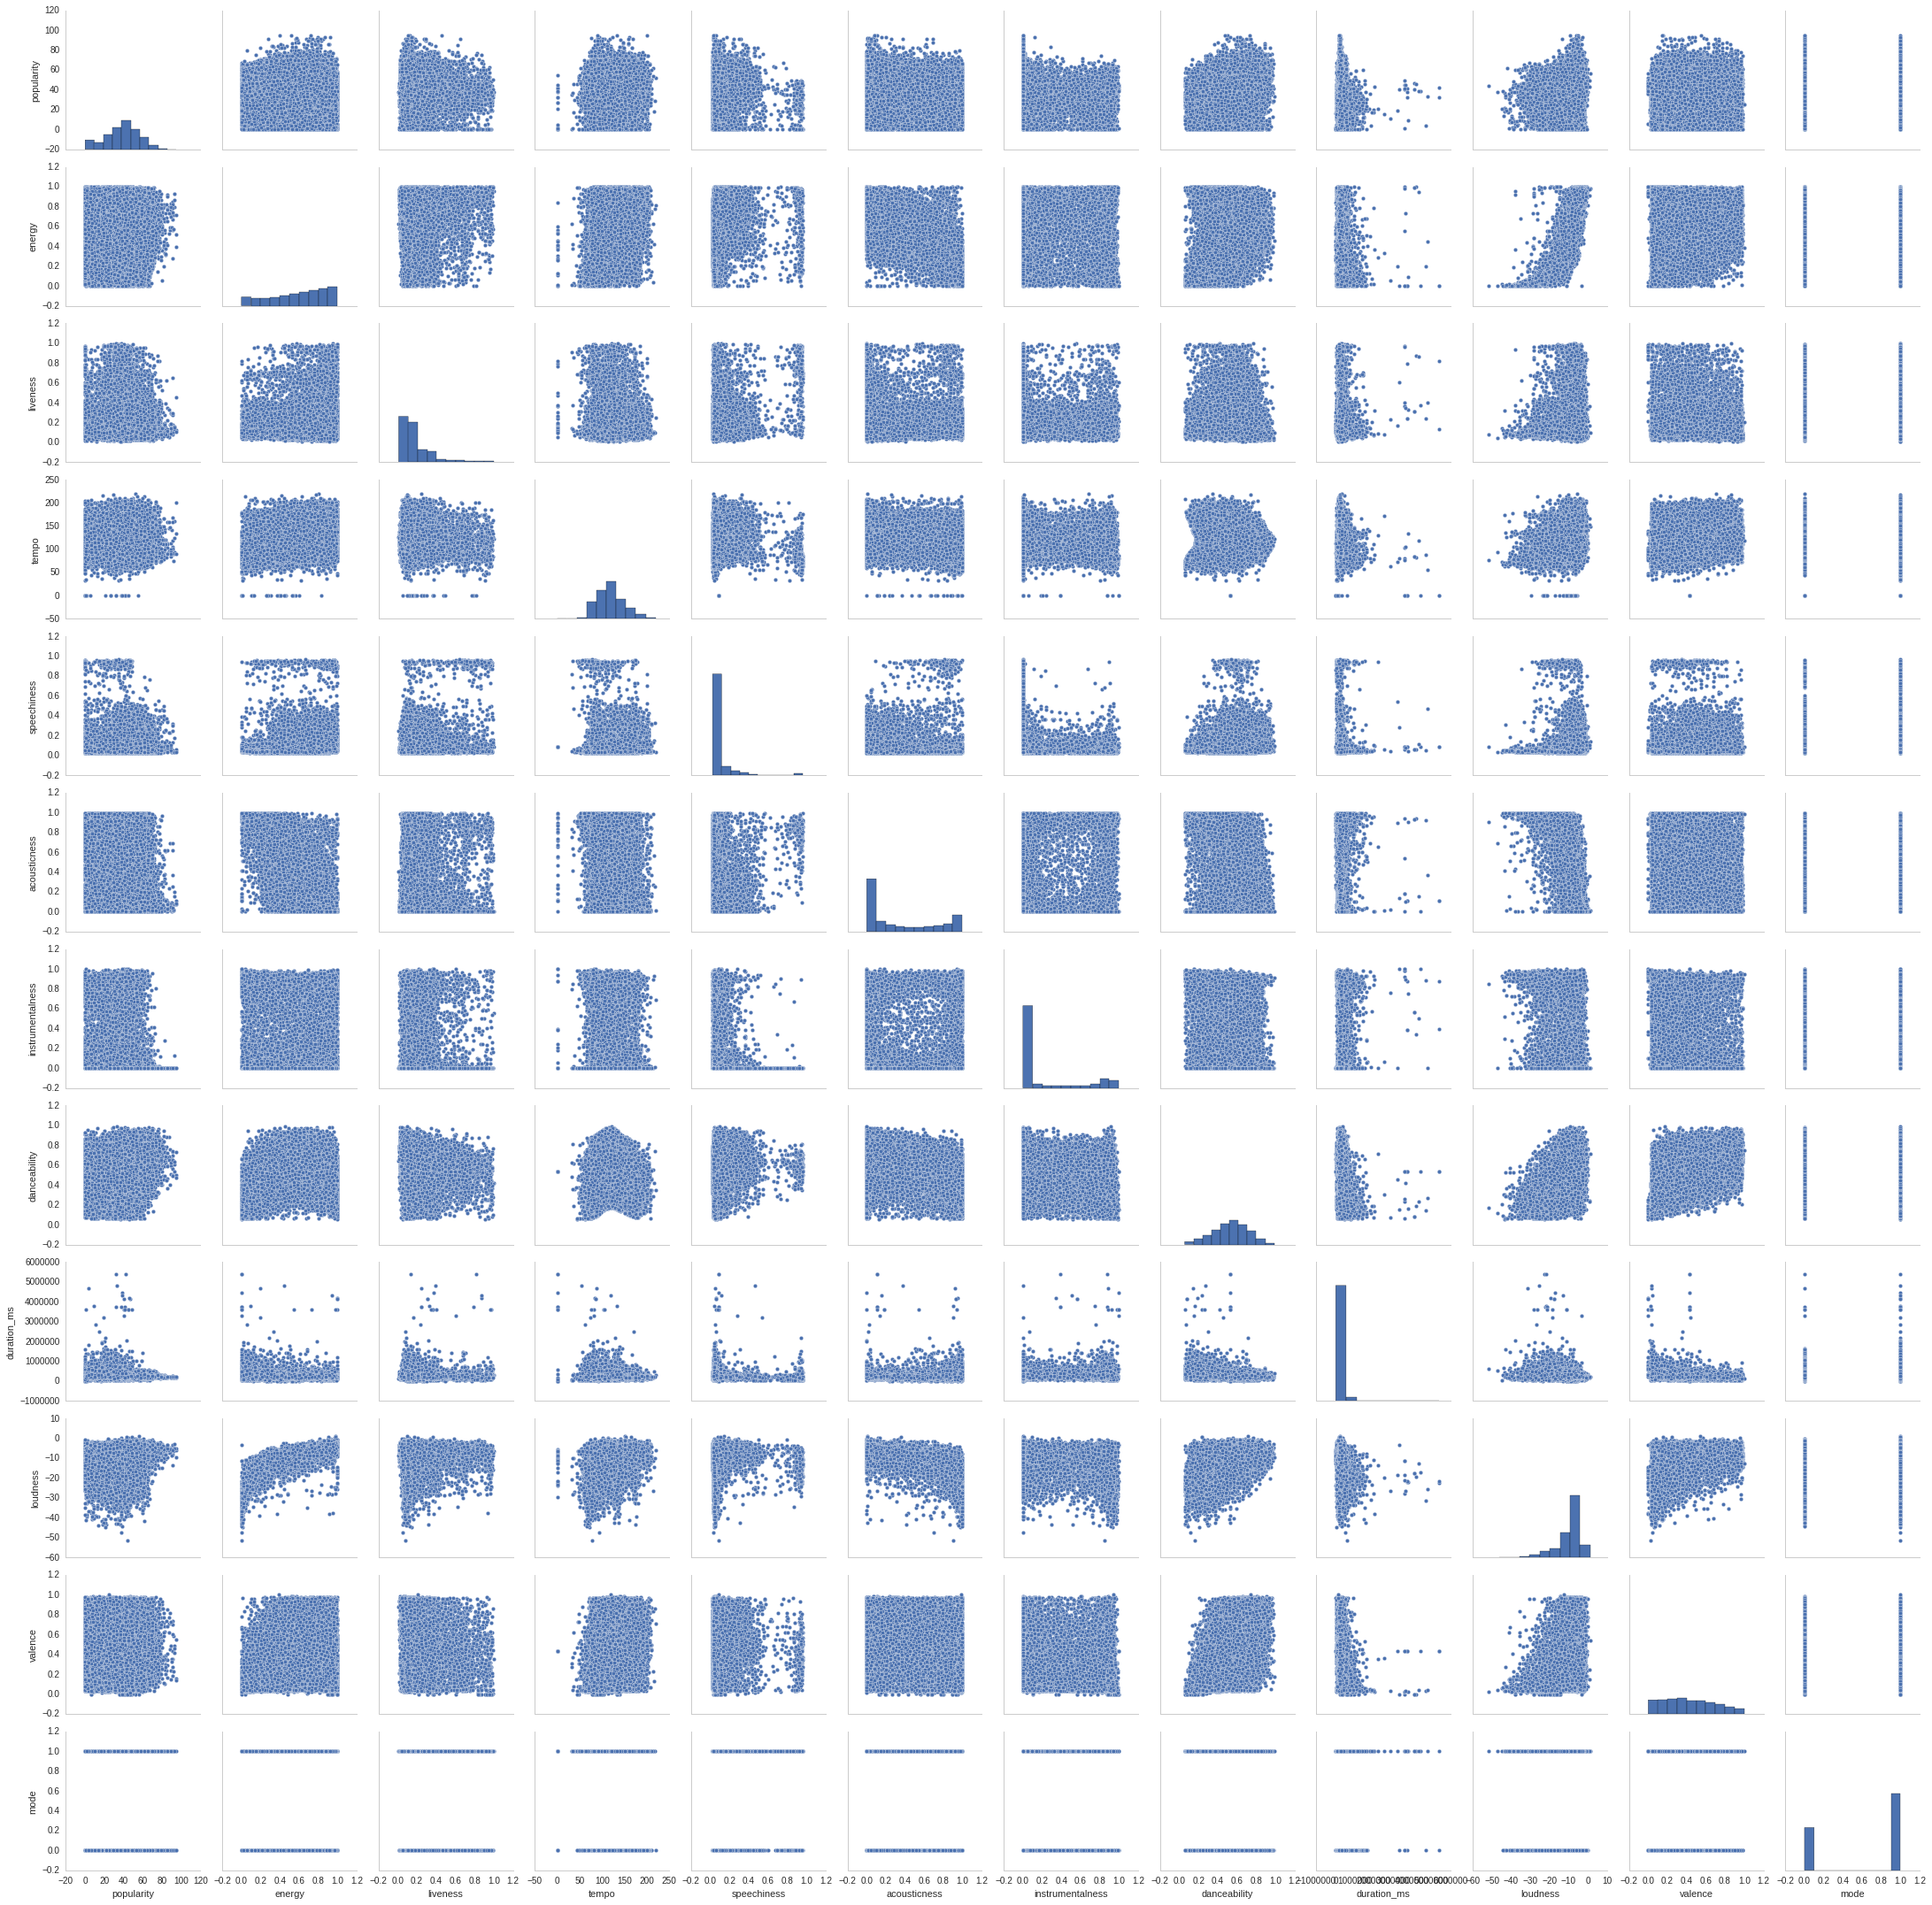

In [27]:
sns.pairplot(master_songs_2[numerical])

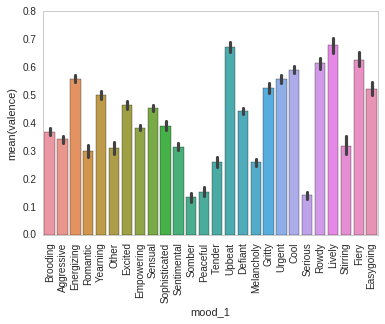

In [62]:
sns.barplot(x = 'mood_1', y = 'valence', data = master_songs_2)
plt.xticks(rotation=90);

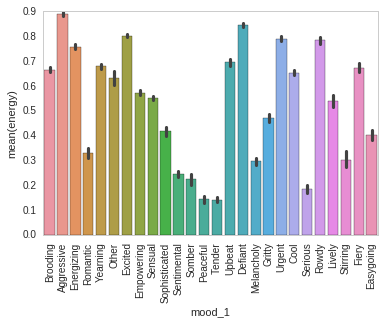

In [63]:
sns.barplot(x = 'mood_1', y = 'energy', data = master_songs_2)
plt.xticks(rotation=90);

In [20]:
master_songs_2.describe()

,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,key,duration_ms,loudness,valence,mode
count,21500.000000,21500.000000,21500.000000,21500.000000,21500.000000,21500.000000,21500.000000,21500.000000,21500.000000,2.150000e+04,21500.000000,21500.000000,21500.000000
mean,38.458419,0.592010,0.189594,119.001707,0.087098,0.341192,0.206672,0.532033,5.213860,2.656936e+05,-9.618780,0.429258,0.642140
std,17.268336,0.286336,0.162499,29.741616,0.127222,0.365957,0.337024,0.182399,3.545474,1.807407e+05,6.350922,0.260649,0.479382
min,0.000000,0.000019,0.009670,0.000000,0.022800,0.000000,0.000000,0.056700,0.000000,5.365000e+03,-51.492000,0.000010,0.000000
25%,28.000000,0.378000,0.094400,96.549250,0.035600,0.013100,0.000002,0.411750,2.000000,1.971600e+05,-11.722500,0.210000,0.000000
50%,40.000000,0.646000,0.122000,119.739500,0.046500,0.160000,0.001100,0.544000,5.000000,2.324530e+05,-7.674000,0.403000,1.000000
75%,50.000000,0.841000,0.234000,136.247250,0.077900,0.703000,0.318250,0.664000,8.000000,2.844490e+05,-5.309750,0.633000,1.000000
max,95.000000,1.000000,0.997000,219.331000,0.964000,0.996000,1.000000,0.988000,11.000000,5.403500e+06,1.258000,0.999000,1.000000


In [21]:
master_songs_2[numerical]

,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,mode
0,48,0.885000,0.1690,138.153,0.035400,0.000032,0.196000,0.470000,215120.0,-7.224,0.780000,1.0
1,58,0.873000,0.1650,142.726,0.038600,0.004680,0.000000,0.499000,134200.0,-3.902,0.869000,1.0
2,30,0.936000,0.1180,127.997,0.042500,0.000531,0.594000,0.715000,201337.0,-6.127,0.106000,0.0
4,28,0.249000,0.1140,116.599,0.045100,0.955000,0.000000,0.533000,272053.0,-8.532,0.513000,0.0
5,5,0.548000,0.1790,76.020,0.028700,0.294000,0.000000,0.376000,343667.0,-10.580,0.233000,0.0
6,67,0.953000,0.3490,171.971,0.062400,0.099600,0.000000,0.516000,192160.0,-3.828,0.849000,1.0
7,0,0.546000,0.1470,72.940,0.961000,0.921000,0.000000,0.611000,222200.0,-10.444,0.491000,1.0
8,56,0.445000,0.1130,110.056,0.050000,0.057500,0.000000,0.702000,226893.0,-9.693,0.326000,0.0
9,56,0.669000,0.1080,99.987,0.048300,0.093700,0.820000,0.633000,355200.0,-8.124,0.038400,0.0
10,54,0.584000,0.0677,106.967,0.036600,0.006580,0.000000,0.834000,195427.0,-7.238,0.964000,0.0


## Initial Model Run / Load Pickle Point

In [6]:
master_songs_2 = pd.read_pickle('data/master_songs_2.pkl')

In [7]:
X, y = master_songs_2[numerical], master_songs_2['mood_1']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

In [38]:
# Using gridsearch to find KNN best parameters
knn = KNeighborsClassifier()

parameters_knn = {'n_neighbors': range(1, 20)}
grid_searcher_knn = grid_search.GridSearchCV(knn, parameters_knn)
grid_searcher_knn.fit(X, y)
print grid_searcher_knn.best_params_

{'n_neighbors': 1}


In [39]:
grid_searcher_knn.best_params_['n_neighbors']

1

In [40]:
models = {}
models['LogR'] = LogisticRegression()
models['KNN'] = KNeighborsClassifier(n_neighbors = grid_searcher_knn.best_params_['n_neighbors'])
models['GNB'] = GaussianNB()
models['SVC'] = SVC()
models['DTC'] = DecisionTreeClassifier()
models['RFC'] = RandomForestClassifier()

for name, model in models.iteritems(): 
    model.fit(X_train, y_train)
    print name, metrics.accuracy_score(y_test, model.predict(X_test))

KNN 0.0911627906977
RFC 0.304341085271
LogR 0.108992248062
DTC 0.225581395349
SVC 0.0821705426357
GNB 0.154418604651


In [43]:
confuse = metrics.confusion_matrix(y_test,models['RFC'].predict(X_test))
print metrics.classification_report(y_test,models['RFC'].predict(X_test))

             precision    recall  f1-score   support

 Aggressive       0.40      0.52      0.45       373
   Brooding       0.20      0.27      0.23       383
       Cool       0.31      0.51      0.38       374
    Defiant       0.37      0.43      0.40       484
  Easygoing       0.14      0.17      0.15       115
 Empowering       0.33      0.42      0.37       518
 Energizing       0.36      0.43      0.39       396
    Excited       0.24      0.24      0.24       401
      Fiery       0.16      0.09      0.12       107
     Gritty       0.15      0.13      0.14       172
     Lively       0.11      0.05      0.07       110
 Melancholy       0.26      0.32      0.29       231
      Other       0.77      0.77      0.77       128
   Peaceful       0.25      0.28      0.26       145
   Romantic       0.20      0.13      0.16       155
      Rowdy       0.15      0.07      0.09       164
    Sensual       0.29      0.27      0.28       468
Sentimental       0.35      0.29      0.32   

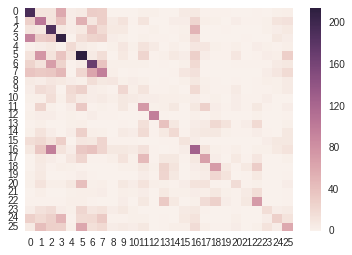

In [45]:
sns.heatmap(confuse);

In [10]:
# Next steps
# Try using standard scaler to scale features
# Use get_dummies with drop_first = True
# Use gridsearch to find best parameters for SVM
# Use PCA to see which features are important prior to running classification algorithms

## Preprocessing and Remodeling

In [12]:
scaler = StandardScaler()
scaler.fit(master_songs_2[numerical])
scaled_data = scaler.transform(master_songs_2[numerical])

In [13]:
master_songs_scaled = pd.DataFrame(scaled_data, columns = numerical)

In [14]:
X, y = master_songs_scaled, master_songs_2['mood_1']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

In [ ]:
# Using gridsearch to find KNN best parameters - DO NOT RERUN - {'n_neighbors': 44}
knn = KNeighborsClassifier()

parameters_knn = {'n_neighbors': range(1, 50)}
grid_searcher_knn = grid_search.GridSearchCV(knn, parameters_knn, verbose=3)
grid_searcher_knn.fit(X, y)
print grid_searcher_knn.best_params_

In [14]:
# Using gridsearch to find SVC best parameters - DO NOT RERUN - {'C': 1, 'gamma': 0.1}
svc = SVC()

parameters_svc = {'C': [0.1, 1, 10, 100, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
grid_searcher_svc = grid_search.GridSearchCV(svc, parameters_svc, verbose=3)
grid_searcher_svc.fit(X, y)
print grid_searcher_svc.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ......................... C=0.1, gamma=1, score=0.150662 -  30.5s
[CV] C=0.1, gamma=1 ..................................................
[CV] ......................... C=0.1, gamma=1, score=0.139288 -  30.3s
[CV] C=0.1, gamma=1 ..................................................
[CV] ......................... C=0.1, gamma=1, score=0.151676 -  30.3s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ....................... C=0.1, gamma=0.1, score=0.313171 -  19.2s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ....................... C=0.1, gamma=0.1, score=0.299372 -  19.8s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ....................... C=0.1, gamma=0.1, score=0.309916 -  19.1s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ...........

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed: 12.3min


[CV] .......................... C=10, gamma=1, score=0.255548 -  35.7s
[CV] C=10, gamma=1 ...................................................
[CV] .......................... C=10, gamma=1, score=0.259916 -  36.4s
[CV] C=10, gamma=0.1 .................................................
[CV] ........................ C=10, gamma=0.1, score=0.321812 -  19.8s
[CV] C=10, gamma=0.1 .................................................
[CV] ........................ C=10, gamma=0.1, score=0.323378 -  20.0s
[CV] C=10, gamma=0.1 .................................................
[CV] ........................ C=10, gamma=0.1, score=0.329190 -  20.6s
[CV] C=10, gamma=0.01 ................................................
[CV] ....................... C=10, gamma=0.01, score=0.332683 -  17.2s
[CV] C=10, gamma=0.01 ................................................
[CV] ....................... C=10, gamma=0.01, score=0.322121 -  17.2s
[CV] C=10, gamma=0.01 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 29.8min finished


{'C': 1, 'gamma': 0.1}


In [95]:
models = {}
# models['LogR'] = LogisticRegression(penalty = 'l1')
# models['KNN'] = KNeighborsClassifier(n_neighbors=grid_searcher_knn.best_params_['n_neighbors'])
# models['GNB'] = GaussianNB()
# models['SVC'] = SVC(C=1, gamma=0.1)
# models['DTC'] = DecisionTreeClassifier()
models['RFC'] = RandomForestClassifier(n_estimators=500)

# Trying other trees
# models['ABC'] = AdaBoostClassifier()
# models['ETC'] = ExtraTreesClassifier()
# models['GBC'] = GradientBoostingClassifier()

for name, model in models.iteritems(): 
    model.fit(X_train, y_train)
    print name, metrics.accuracy_score(y_test, model.predict(X_test))

RFC 0.386046511628


In [75]:
confuse = metrics.confusion_matrix(y_test,models['RFC'].predict(X_test))
print metrics.classification_report(y_test,models['RFC'].predict(X_test))

             precision    recall  f1-score   support

 Aggressive       0.52      0.56      0.54       377
   Brooding       0.36      0.37      0.37       375
       Cool       0.39      0.53      0.45       374
    Defiant       0.42      0.49      0.45       491
  Easygoing       0.30      0.17      0.22       121
 Empowering       0.39      0.56      0.46       491
 Energizing       0.41      0.50      0.45       398
    Excited       0.33      0.35      0.34       427
      Fiery       0.39      0.08      0.13       117
     Gritty       0.32      0.11      0.17       184
     Lively       0.24      0.14      0.18        83
 Melancholy       0.39      0.38      0.38       241
      Other       0.86      0.79      0.83       140
   Peaceful       0.27      0.29      0.28       122
   Romantic       0.25      0.08      0.13       143
      Rowdy       0.35      0.13      0.18       183
    Sensual       0.35      0.50      0.41       468
Sentimental       0.35      0.42      0.38   

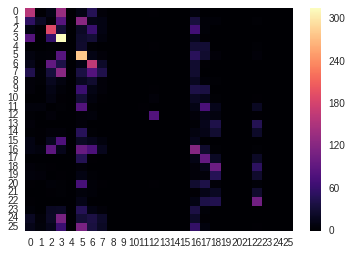

In [101]:
sns.heatmap(confuse, cmap='magma')

In [92]:
rfc = RandomForestClassifier()

# param_grid = {"max_depth": [3],
#               "max_features": [1, 3, 10],
#               "min_samples_split": [1, 3, 10],
#               "min_samples_leaf": [1, 3, 10],
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}

rfc_estimator = grid_search.GridSearchCV(rfc, param_grid, verbose=3)
rfc_estimator.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] bootstrap=True, min_samples_leaf=1, min_samples_split=1, criterion=gini, max_features=1, max_depth=3 
[CV]  bootstrap=True, min_samples_leaf=1, min_samples_split=1, criterion=gini, max_features=1, max_depth=3, score=0.232438 -   0.1s
[CV] bootstrap=True, min_samples_leaf=1, min_samples_split=1, criterion=gini, max_features=1, max_depth=3 
[CV]  bootstrap=True, min_samples_leaf=1, min_samples_split=1, criterion=gini, max_features=1, max_depth=3, score=0.233911 -   0.1s
[CV] bootstrap=True, min_samples_leaf=1, min_samples_split=1, criterion=gini, max_features=1, max_depth=3 
[CV]  bootstrap=True, min_samples_leaf=1, min_samples_split=1, criterion=gini, max_features=1, max_depth=3, score=0.243907 -   0.1s
[CV] bootstrap=True, min_samples_leaf=1, min_samples_split=3, criterion=gini, max_features=1, max_depth=3 
[CV]  bootstrap=True, min_samples_leaf=1, min_samples_split=3, criterion=gini, max_features=1, max_depth=3, score

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    3.1s


[CV]  bootstrap=True, min_samples_leaf=1, min_samples_split=3, criterion=gini, max_features=3, max_depth=3, score=0.249054 -   0.1s
[CV] bootstrap=True, min_samples_leaf=1, min_samples_split=3, criterion=gini, max_features=3, max_depth=3 
[CV]  bootstrap=True, min_samples_leaf=1, min_samples_split=3, criterion=gini, max_features=3, max_depth=3, score=0.260487 -   0.1s
[CV] bootstrap=True, min_samples_leaf=1, min_samples_split=10, criterion=gini, max_features=3, max_depth=3 
[CV]  bootstrap=True, min_samples_leaf=1, min_samples_split=10, criterion=gini, max_features=3, max_depth=3, score=0.250547 -   0.1s
[CV] bootstrap=True, min_samples_leaf=1, min_samples_split=10, criterion=gini, max_features=3, max_depth=3 
[CV]  bootstrap=True, min_samples_leaf=1, min_samples_split=10, criterion=gini, max_features=3, max_depth=3, score=0.254433 -   0.1s
[CV] bootstrap=True, min_samples_leaf=1, min_samples_split=10, criterion=gini, max_features=3, max_depth=3 
[CV]  bootstrap=True, min_samples_leaf=

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:   28.6s


[CV]  bootstrap=True, min_samples_leaf=10, min_samples_split=1, criterion=entropy, max_features=3, max_depth=3, score=0.261606 -   0.5s
[CV] bootstrap=True, min_samples_leaf=10, min_samples_split=1, criterion=entropy, max_features=3, max_depth=3 
[CV]  bootstrap=True, min_samples_leaf=10, min_samples_split=1, criterion=entropy, max_features=3, max_depth=3, score=0.262885 -   0.5s
[CV] bootstrap=True, min_samples_leaf=10, min_samples_split=3, criterion=entropy, max_features=3, max_depth=3 
[CV]  bootstrap=True, min_samples_leaf=10, min_samples_split=3, criterion=entropy, max_features=3, max_depth=3, score=0.257114 -   0.5s
[CV] bootstrap=True, min_samples_leaf=10, min_samples_split=3, criterion=entropy, max_features=3, max_depth=3 
[CV]  bootstrap=True, min_samples_leaf=10, min_samples_split=3, criterion=entropy, max_features=3, max_depth=3, score=0.253238 -   0.5s
[CV] bootstrap=True, min_samples_leaf=10, min_samples_split=3, criterion=entropy, max_features=3, max_depth=3 
[CV]  bootst

[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:  1.7min


[CV]  bootstrap=False, min_samples_leaf=3, min_samples_split=10, criterion=entropy, max_features=3, max_depth=3, score=0.250499 -   0.6s
[CV] bootstrap=False, min_samples_leaf=10, min_samples_split=1, criterion=entropy, max_features=3, max_depth=3 
[CV]  bootstrap=False, min_samples_leaf=10, min_samples_split=1, criterion=entropy, max_features=3, max_depth=3, score=0.253731 -   0.6s
[CV] bootstrap=False, min_samples_leaf=10, min_samples_split=1, criterion=entropy, max_features=3, max_depth=3 
[CV]  bootstrap=False, min_samples_leaf=10, min_samples_split=1, criterion=entropy, max_features=3, max_depth=3, score=0.256027 -   0.6s
[CV] bootstrap=False, min_samples_leaf=10, min_samples_split=1, criterion=entropy, max_features=3, max_depth=3 
[CV]  bootstrap=False, min_samples_leaf=10, min_samples_split=1, criterion=entropy, max_features=3, max_depth=3, score=0.263883 -   0.5s
[CV] bootstrap=False, min_samples_leaf=10, min_samples_split=3, criterion=entropy, max_features=3, max_depth=3 
[CV]

[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:  2.6min finished


In [93]:
print rfc_estimator.best_params_
print rfc_estimator.best_score_

{'bootstrap': True, 'min_samples_leaf': 3, 'min_samples_split': 10, 'criterion': 'gini', 'max_features': 3, 'max_depth': 3}
0.261860465116


In [94]:
confuse = metrics.confusion_matrix(y_test,rfc_estimator.predict(X_test))
print metrics.classification_report(y_test,rfc_estimator.predict(X_test))

             precision    recall  f1-score   support

 Aggressive       0.33      0.41      0.37       384
   Brooding       0.26      0.06      0.10       359
       Cool       0.30      0.47      0.37       400
    Defiant       0.28      0.58      0.38       542
  Easygoing       0.00      0.00      0.00       100
 Empowering       0.22      0.57      0.32       491
 Energizing       0.25      0.44      0.32       380
    Excited       0.21      0.11      0.14       398
      Fiery       0.00      0.00      0.00       113
     Gritty       0.00      0.00      0.00       184
     Lively       0.00      0.00      0.00       100
 Melancholy       0.18      0.01      0.02       226
      Other       0.83      0.60      0.70       134
   Peaceful       0.00      0.00      0.00       119
   Romantic       0.00      0.00      0.00       144
      Rowdy       0.00      0.00      0.00       172
    Sensual       0.17      0.26      0.21       466
Sentimental       0.19      0.47      0.27   

/home/neokt/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## PCA w/ 2 Components

In [16]:
pca = decomposition.PCA(n_components=2)
pca.fit(master_songs_scaled)
master_songs_pca = pca.transform(master_songs_scaled)

In [17]:
master_songs_pca.shape

(21500, 2)

In [18]:
all_pca = pd.concat([pd.DataFrame(master_songs_pca), master_songs_2.reset_index()['mood_1']], axis=1, ignore_index=True)

In [19]:
all_pca.head()

,0,1,2
0,-1.577374,-0.373083,Brooding
1,-2.333362,-0.798319,Aggressive
2,-0.772710,0.269334,Energizing
3,1.064054,-0.772548,Romantic
4,1.093944,0.678104,Brooding


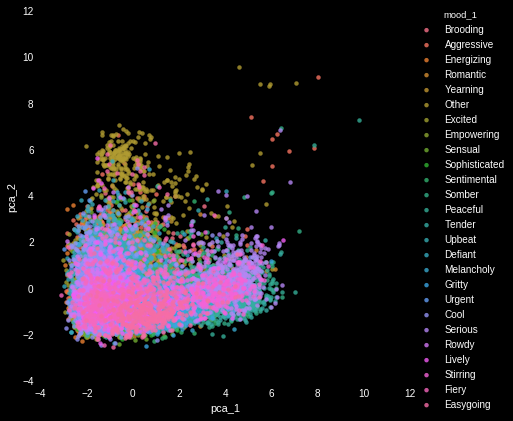

In [45]:
all_pca.columns = ['pca_1', 'pca_2', 'mood_1']


sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False, 'text.color': 'white', 
             'xtick.color': 'white', 'ytick.color': 'white', 'axes.labelcolor': 'white', 'axes.edgecolor': 'white'} )

sns.lmplot('pca_1', 'pca_2', data=all_pca, hue='mood_1', fit_reg=False, size=6)
plt.savefig('pca.png')


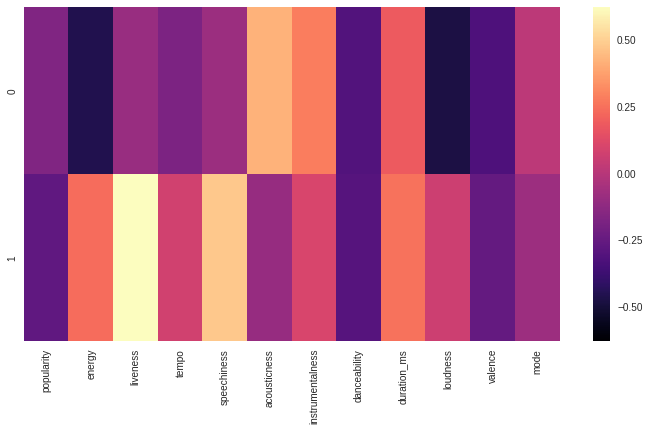

In [33]:
pca_df = pd.DataFrame(pca.components_, columns = master_songs_scaled.columns)
plt.figure(figsize=(12, 6))
sns.heatmap(pca_df, cmap = 'magma');

In [34]:
all_pca.head()

,pca_1,pca_2,mood_1
0,-1.577374,-0.373083,Brooding
1,-2.333362,-0.798319,Aggressive
2,-0.772710,0.269334,Energizing
3,1.064054,-0.772548,Romantic
4,1.093944,0.678104,Brooding


In [35]:
X, y = all_pca.drop('mood_1', axis=1), all_pca['mood_1']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

In [111]:
models = {}
models['LogR'] = LogisticRegression()
models['KNN'] = KNeighborsClassifier()
models['GNB'] = GaussianNB()
models['SVC'] = SVC()
models['DTC'] = DecisionTreeClassifier()
models['RFC'] = RandomForestClassifier()

for name, model in models.iteritems(): 
    model.fit(X_train, y_train)
    print name, metrics.accuracy_score(y_test, model.predict(X_test))

KNN 0.136744186047
RFC 0.133333333333
LogR 0.19519379845
DTC 0.11984496124
SVC 0.20511627907
GNB 0.201395348837


## PCA with more components

In [134]:
pca = decomposition.PCA(n_components=10)
pca.fit(master_songs_scaled)
master_songs_pca = pca.transform(master_songs_scaled)

In [135]:
all_pca = pd.concat([pd.DataFrame(master_songs_pca), master_songs_2.reset_index()['mood_1']], axis=1, ignore_index=True)

In [136]:
X, y = all_pca.drop(10, axis=1), all_pca[10]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

In [137]:
models = {}
models['LogR'] = LogisticRegression()
models['KNN'] = KNeighborsClassifier()
models['GNB'] = GaussianNB()
models['SVC'] = SVC()
models['DTC'] = DecisionTreeClassifier()
models['RFC'] = RandomForestClassifier()

for name, model in models.iteritems(): 
    model.fit(X_train, y_train)
    print name, metrics.accuracy_score(y_test, model.predict(X_test))

KNN 0.249457364341
RFC 0.256589147287
LogR 0.292713178295
DTC 0.18496124031
SVC 0.328837209302
GNB 0.273643410853


##  Chaining PCA and RFC, SVC

In [76]:
# rescaling
scaler = StandardScaler()
scaler.fit(master_songs_2[numerical])
scaled_data = scaler.transform(master_songs_2[numerical])

In [77]:
master_songs_scaled = pd.DataFrame(scaled_data, columns = numerical)

In [78]:
X, y = master_songs_scaled, master_songs_2['mood_1']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

In [79]:
pca_svc = SVC()
# pca_rfc = RandomForestClassifier()

pca = decomposition.PCA(n_components=10)
pipe = pipeline.Pipeline(steps=[('pca', pca), ('svc', pca_svc)])

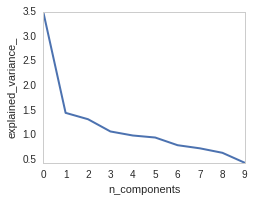

In [80]:
pca.fit(X_train)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [ ]:
# Don't run!!!
n_components = range(2, 12)
C = [0.1, 1, 10, 100, 100]
gamma = [1, 0.1, 0.01, 0.001, 0.0001]

#Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = grid_search.GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              svc__C=C, svc__gamma=gamma), verbose=3, n_jobs=2)
estimator.fit(X_train, y_train)

In [ ]:
# Do not need to rerun 
# best_params_: {'pca__n_components': 10 for default n_estimators = 10}
n_components = range(2, 12)
pca_rfc = RandomForestClassifier(n_estimators=300)

param_grid = {"max_depth": [3],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

pca = decomposition.PCA()
pipe = pipeline.Pipeline(steps=[('pca', pca), ('rfc', pca_rfc)])

#Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = grid_search.GridSearchCV(pipe,
                         dict(pca__n_components=n_components), verbose=3)

estimator.fit(X_train, y_train)
print estimator.best_params_
print estimator.best_score_

In [ ]:
param_grid = {"max_depth": [3],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

pca = decomposition.PCA(n_components=10)
pca_rfc = RandomForestClassifier()

#Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = grid_search.GridSearchCV(pca_rfc, param_grid=param_grid, verbose=3)

estimator.fit(X_train, y_train)

In [82]:
estimator.best_params_

{'pca__n_components': 10}

In [83]:
confuse = metrics.confusion_matrix(y_test,estimator.predict(X_test))
print metrics.classification_report(y_test,estimator.predict(X_test))

             precision    recall  f1-score   support

 Aggressive       0.28      0.37      0.32       371
   Brooding       0.16      0.22      0.18       356
       Cool       0.24      0.37      0.30       386
    Defiant       0.31      0.35      0.33       530
  Easygoing       0.13      0.14      0.13       117
 Empowering       0.27      0.38      0.31       485
 Energizing       0.31      0.36      0.33       398
    Excited       0.20      0.18      0.19       409
      Fiery       0.08      0.03      0.05       121
     Gritty       0.13      0.09      0.11       188
     Lively       0.11      0.08      0.10        84
 Melancholy       0.23      0.26      0.24       235
      Other       0.72      0.71      0.71       120
   Peaceful       0.26      0.31      0.28       148
   Romantic       0.12      0.08      0.10       158
      Rowdy       0.11      0.05      0.07       171
    Sensual       0.24      0.26      0.25       457
Sentimental       0.21      0.18      0.20   